# Analysis of cortical network model

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from tqdm import tqdm
from network import NeuralNetwork
from logger import logger
from utils import *

t0 = time.perf_counter()

## Input parameters

In [3]:
# Drive parameters
drive_freq = 7  # presynaptic drive frequency (Hz)
noise = 0.05  # noise factor

# Stimulus parameters
start = 250 # start time (ms)
dur = 150  # duration (ms)
Pref = 1e6  # pressure amplitude (Pa)
Pmax = 3e6  # maximum pressure amplitude (Pa)
Iref = pressure_to_intensity(Pref) / 1e4  # corresponding intensity (W/cm2)
Imax = pressure_to_intensity(Pmax) / 1e4  # corresponding intensity (W/cm2)
Isppa_range = sqrtspace(0, Imax, 15)  # range of intensities to sweep

# Simulation parameters
tstop = 700  # default simulation duration (ms)
nreps = 1  # number of repetitions per simulation (for sweep trends)

# Logging
paramsstr = {
    'drive': [
        f'frequency = {drive_freq} Hz',
        f'noise factor = {noise}'],
    'stimulus': [
        f'start = {start} ms',
        f'duration = {dur} ms',
        f'P = {Pref * 1e-6:.1f} MPa <-> I = {Iref:.2f} W/cm2',
        f'range of intensities = {Isppa_range[0]:.2f} - {Isppa_range[-1]:.2f} W/cm2'],
    'simulation': [
        f'duration = {tstop} ms',
        f'number of repetitions (for sweeps) = {nreps}']
}
paramsstr = {k: '\n'.join([f'       - {x}' for x in v]) for k, v in paramsstr.items()}
paramsstr = '\n'.join([f'   - {k}:\n{v}' for k, v in paramsstr.items()]) 
logger.info('Input parameters:\n' + paramsstr)

 09/12/2023 17:28:47: Input parameters:
   - drive:
       - frequency = 7 Hz
       - noise factor = 0.05
   - stimulus:
       - start = 250 ms
       - duration = 150 ms
       - P = 1.0 MPa <-> I = 30.91 W/cm2
       - range of intensities = 0.00 - 278.22 W/cm2
   - simulation:
       - duration = 700 ms
       - number of repetitions (for sweeps) = 1


## Network model

In [4]:
# Initialize 3-nodes model temperature-dependent components
nnodes = 3
model = NeuralNetwork(
    nnodes, 
    Q10_rates=3,
    Q10_gNa=1.40,
    Q10_gKd=4.75,
    gKT=0.58e-9 / (NeuralNetwork.Acell * NeuralNetwork.UM_TO_CM**2),  # S/cm2
)

 09/12/2023 17:28:51: NeuralNetwork(3): created 3 nodes
 09/12/2023 17:28:51: NeuralNetwork(3): connecting all node pairs
 09/12/2023 17:28:51: NeuralNetwork(3): setting Q10_rates = 3 on all nodes
 09/12/2023 17:28:51: NeuralNetwork(3): setting Q10_gNa = 1.4 on all nodes
 09/12/2023 17:28:51: NeuralNetwork(3): setting Q10_gKd = 4.75 on all nodes
 09/12/2023 17:28:51: NeuralNetwork(3): setting gKT = 4.898648648648648e-06 on all nodes
 09/12/2023 17:28:51: NeuralNetwork(3): initialized


## Simulations

### Explore combined impact of synaptic coupling and stimulus sensitivity on evoked activity in single-node vs multi-node stimulation

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 59.46it/s]

 09/12/2023 17:32:51: NeuralNetwork(3): setting iStimbar = 0.003 on all nodes



100%|██████████| 15/15 [00:00<00:00, 61.85it/s]

 09/12/2023 17:32:51: NeuralNetwork(3): setting iStimbar = 0.004 on all nodes



100%|██████████| 15/15 [00:00<00:00, 55.83it/s]

 09/12/2023 17:32:52: NeuralNetwork(3): setting iStimbar = 0.005 on all nodes



100%|██████████| 15/15 [00:00<00:00, 47.86it/s]

 09/12/2023 17:32:53: NeuralNetwork(3): setting iStimbar = 0.006 on all nodes



100%|██████████| 15/15 [00:00<00:00, 42.05it/s]

 09/12/2023 17:32:53: NeuralNetwork(3): setting iStimbar = 0.002 on all nodes



100%|██████████| 15/15 [00:00<00:00, 64.90it/s]

 09/12/2023 17:32:54: NeuralNetwork(3): setting iStimbar = 0.003 on all nodes



100%|██████████| 15/15 [00:00<00:00, 54.22it/s]

 09/12/2023 17:32:54: NeuralNetwork(3): setting iStimbar = 0.004 on all nodes



100%|██████████| 15/15 [00:00<00:00, 42.35it/s]

 09/12/2023 17:32:55: NeuralNetwork(3): setting iStimbar = 0.005 on all nodes



100%|██████████| 15/15 [00:00<00:00, 43.11it/s]

 09/12/2023 17:32:56: NeuralNetwork(3): setting iStimbar = 0.006 on all nodes



100%|██████████| 15/15 [00:00<00:00, 35.41it/s]

 09/12/2023 17:32:57: NeuralNetwork(3): setting iStimbar = 0.002 on all nodes



100%|██████████| 15/15 [00:00<00:00, 57.85it/s]

 09/12/2023 17:32:57: NeuralNetwork(3): setting iStimbar = 0.003 on all nodes



100%|██████████| 15/15 [00:00<00:00, 45.13it/s]

 09/12/2023 17:32:58: NeuralNetwork(3): setting iStimbar = 0.004 on all nodes



100%|██████████| 15/15 [00:00<00:00, 36.80it/s]

 09/12/2023 17:32:58: NeuralNetwork(3): setting iStimbar = 0.005 on all nodes



100%|██████████| 15/15 [00:00<00:00, 28.67it/s]

 09/12/2023 17:32:59: NeuralNetwork(3): setting iStimbar = 0.006 on all nodes



100%|██████████| 15/15 [00:00<00:00, 23.24it/s]

 09/12/2023 17:33:00: NeuralNetwork(3): setting iStimbar = 0.002 on all nodes



100%|██████████| 15/15 [00:00<00:00, 37.45it/s]

 09/12/2023 17:33:01: NeuralNetwork(3): setting iStimbar = 0.003 on all nodes



100%|██████████| 15/15 [00:00<00:00, 25.61it/s]

 09/12/2023 17:33:02: NeuralNetwork(3): setting iStimbar = 0.004 on all nodes



100%|██████████| 15/15 [00:00<00:00, 21.93it/s]

 09/12/2023 17:33:03: NeuralNetwork(3): setting iStimbar = 0.005 on all nodes



100%|██████████| 15/15 [00:00<00:00, 20.12it/s]

 09/12/2023 17:33:05: NeuralNetwork(3): setting iStimbar = 0.006 on all nodes



100%|██████████| 15/15 [00:00<00:00, 19.13it/s]

 09/12/2023 17:33:06: plotting Isppa dependencies...


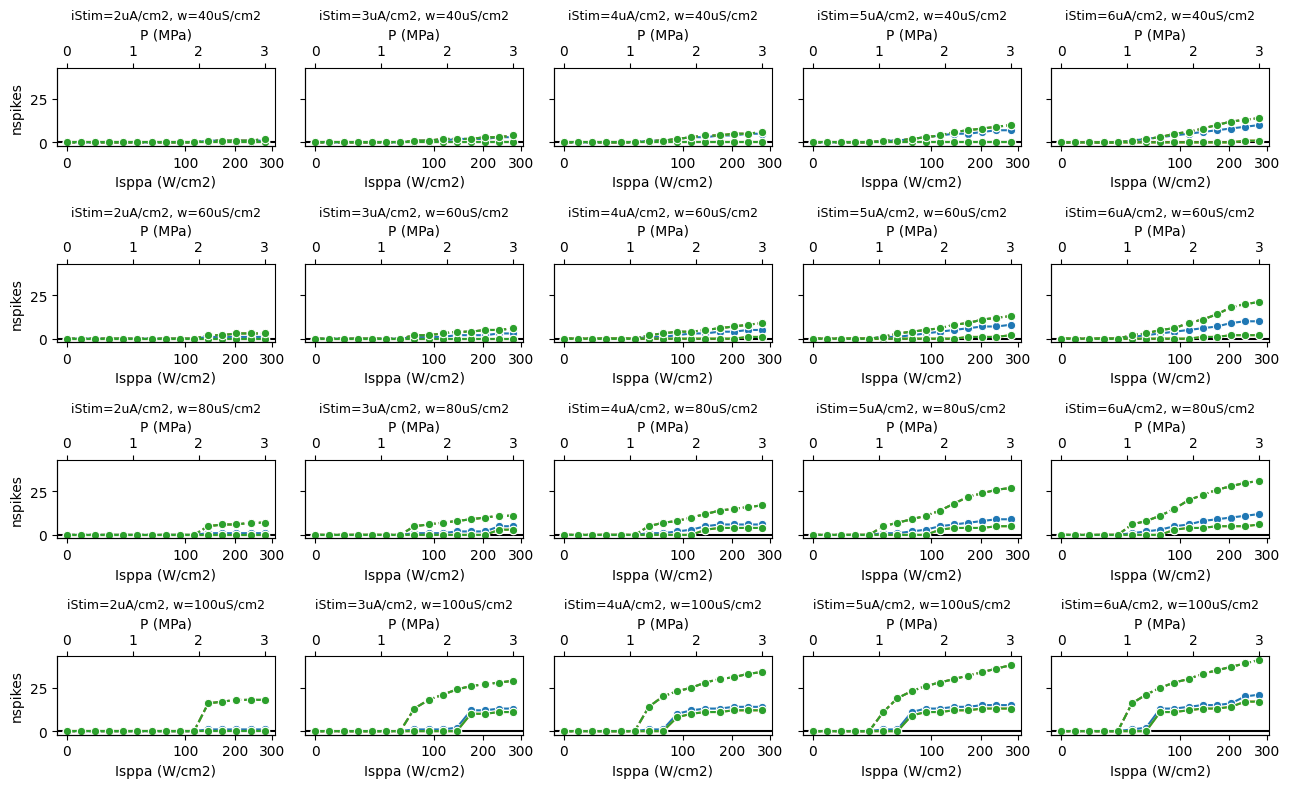

In [6]:
# Define vectors of synaptic weights and stimulus intensities
wrange = np.array([4, 6, 8, 10]) * 1e-5  # S/cm2
iStimbar_range = np.array([2, 3, 4, 5, 6]) * 1e-3  # mA/cm2

# Set stimulus other sensitivity parameters
model.set_mech_param(iStimdx=300)  # W/cm2

# Set stimulus
model.set_stim(Iref, start=start, dur=dur)

# Initialize metric container
metric = []

# For each synaptic weight value
for w in wrange:
    # Set synaptic weight parameter
    model.set_synaptic_weight(w)
    
    # For each stimulus sensitivity value
    for iStimbar in iStimbar_range:
        # Set stimulus sensitivity parameter
        model.set_mech_param(iStimbar=iStimbar)

        # Run comparative Isppa sweep for each stimulus distribution, compute metric
        # and append to container
        metric.append(
            model.run_comparative_sweep(Isppa_range, 'nspikes', tstop=tstop))

# Concatenate results
metric = model.concatenate_outputs(
    list(itertools.product(wrange * 1e6, iStimbar_range * 1e3)), 
    metric, 
    ['w (uS/cm2)', 'iStimbar (uA/cm2)']
)

# Plot Isppa dependencies
logger.info('plotting Isppa dependencies...')
fg = sns.FacetGrid(
    metric.reset_index(),
    col='iStimbar (uA/cm2)',
    row='w (uS/cm2)',
    aspect=1.3,
    height=2,
    sharex=False,
)
fg.set_titles('iStim={col_name:.0f}uA/cm2, w={row_name:.0f}uS/cm2')
for iw, w in enumerate(wrange):
    for ix, iStimbar in enumerate(iStimbar_range):
        model.plot_sweep_results(
            metric.loc[w * 1e6, iStimbar * 1e3],
            ax=fg.axes[iw, ix], 
            legend=iw == wrange.size // 2 and ix == iStimbar_range.size - 1,
            xscale='sqrt',
        )
fg.refline(y=0, linestyle='-', color='k', zorder=-1)
fig = fg.figure
fig.tight_layout()
for ax in fig.axes:
    ax.set_title(ax.get_title(), fontsize=9)

### Set baseline drive and inspect activity with various synaptic coupling strengths

 08/12/2023 19:52:12: NeuralNetwork(3): setting pre-synaptic drive on nodes [0, 1, 2]
 08/12/2023 19:52:12: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 72.3 ms
 08/12/2023 19:52:12: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 70.4 ms
 08/12/2023 19:52:12: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 72.4 ms


100%|██████████| 10/10 [00:00<00:00, 14.74it/s]

 08/12/2023 19:52:13: NeuralNetwork(3): setting all synaptic weights to 1.00e-05 S/cm2
 08/12/2023 19:52:13: NeuralNetwork(3): setting start time of pre-synaptic drive 0 to 69.06 ms...
 08/12/2023 19:52:13: NeuralNetwork(3): setting start time of pre-synaptic drive 1 to 68.85 ms...
 08/12/2023 19:52:13: NeuralNetwork(3): setting start time of pre-synaptic drive 2 to 67.90 ms...
 08/12/2023 19:52:13: NeuralNetwork(3): disabled currents: iNaKPump
 08/12/2023 19:52:13: NeuralNetwork(3): simulating for 700.00 ms
 08/12/2023 19:52:13: NeuralNetwork(3): extracting output results


 08/12/2023 19:52:13: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.0 °C
    - node 1: ΔT = 0.0 °C
    - node 2: ΔT = 0.0 °C
 08/12/2023 19:52:13: NeuralNetwork(3): number of spikes:
    - node 0: n = 5 spikes
    - node 1: n = 5 spikes
    - node 2: n = 5 spikes
 08/12/2023 19:52:13: NeuralNetwork(3): firing rate:
    - node 0: FR = 7.1 ±0.2  FR
    - node 1: FR = 6.9 ±0.3  FR
    - node 2: FR = 7.1 ±0.1  FR
 08/12/2023 19:52:13: NeuralNetwork(3): number of non-artificial spikes:
    - node 0: n = 0 spikes
    - node 1: n = 0 spikes
    - node 2: n = 0 spikes
 08/12/2023 19:52:13: NeuralNetwork(3): plotting results
 08/12/2023 19:52:14: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 08/12/2023 19:52:14: NeuralNetwork(3): setting start time of pre-synaptic drive 0 to 74.73 ms...
 08/12/2023 19:52:14: NeuralNetwork(3): setting start time of pre-synaptic drive 1 to 69.18 ms...
 08/12/2023 19:52:14: NeuralNetwork(3): setting start time of pre-synaptic

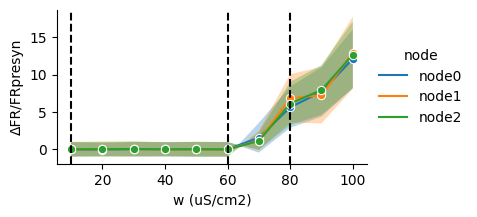

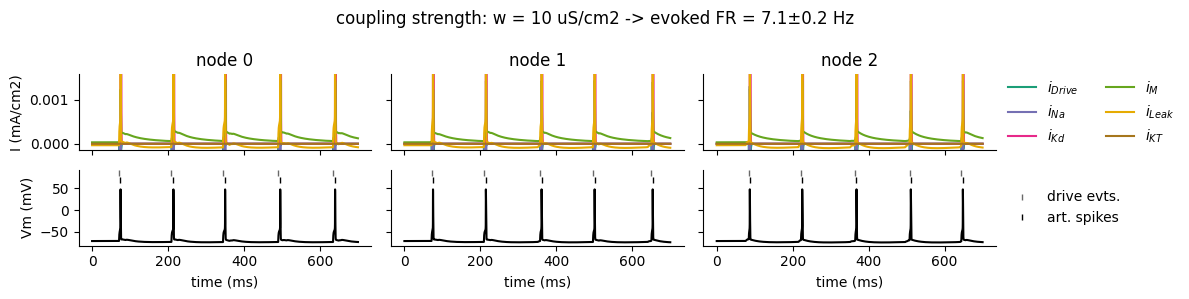

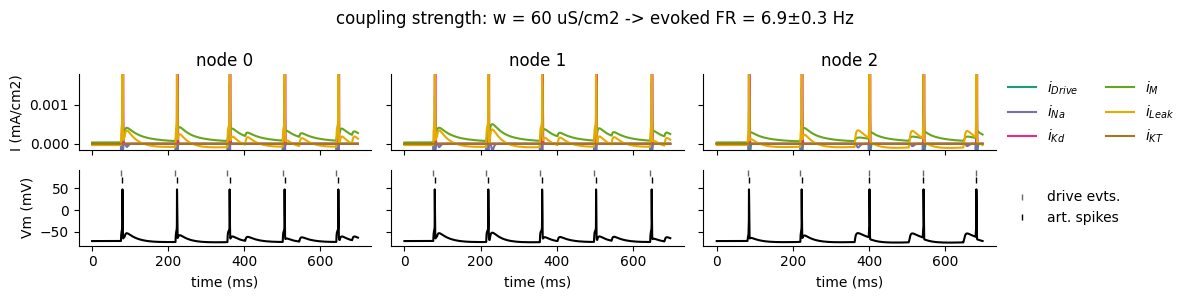

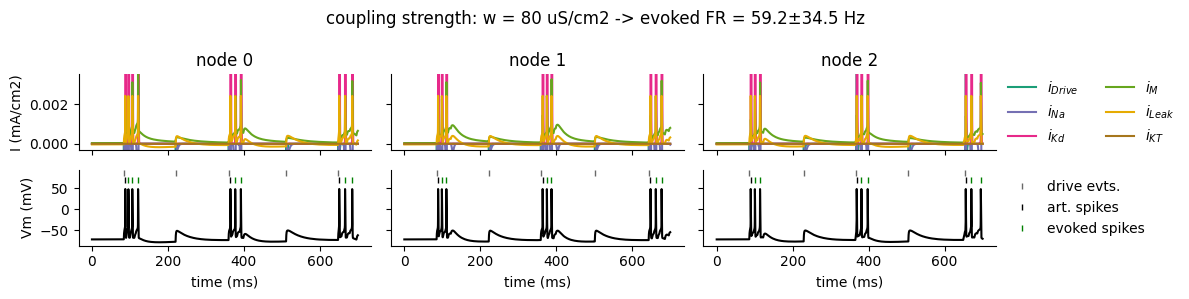

In [5]:
# Assign baseline pre-synaptic drive, and remove stimulus (if any)
model.set_presyn_drive(freq=drive_freq, noise=noise)

# Define vector of coupling strengths (in S/cm2)
wrange = np.linspace(10, 100, 10) * 1e-6

# Run simulations over coupling strength range, and extract metric
metric = []
model.verbose = False
for w in tqdm(wrange):
    model.set_synaptic_weight(w)
    data = model.simulate(tstop=tstop)
    metric.append(model.compute_metric(data, 'ΔFR/FRpresyn'))
model.verbose = True
metric = model.concatenate_outputs(wrange * 1e6, metric, 'w (uS/cm2)')

# Plot dependency of evoked firing rate on coupling strength
fig = model.plot_sweep_results(metric)
ax = fig.axes[0]

# Select subset of coupling strengths for which to plot results
iws = [0, 5, 7]
for w in wrange[iws]:
    model.set_synaptic_weight(w)
    data = model.simulate()
    mu_FR, err_FR = model.compute_metric(data, 'FR').mean(axis=0)
    FR_str = 'N/A' if mu_FR is None else f'{mu_FR:.1f}±{err_FR:.1f} Hz'
    fig = model.plot_results(data, exclude=['conductances', 'T'], clip_currents=True)
    fig.suptitle(f'coupling strength: w = {w * 1e6:.0f} uS/cm2 -> evoked FR = {FR_str}')
    ax.axvline(w * 1e6, color='k', linestyle='--')

# Set synaptic weight to default value
model.set_synaptic_weight(model.g_RS_RS)

### Compare evoked responses and Isppa dependencies for single node vs. multi-node stimulation 

 08/12/2023 19:52:16: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 08/12/2023 19:52:16: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 30.9 W/cm2
    - node 1: 30.9 W/cm2
    - node 2: 30.9 W/cm2
 08/12/2023 19:52:16: NeuralNetwork(3): setting iStimbar = 0.003 on all nodes


 08/12/2023 19:52:16: NeuralNetwork(3): setting iStimdx = 300 on all nodes
 08/12/2023 19:52:16: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


 08/12/2023 19:52:20: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.41it/s]


 08/12/2023 19:52:25: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 150.0 W/cm2
    - node 1: 0.0 W/cm2
    - node 2: 0.0 W/cm2
 08/12/2023 19:52:25: NeuralNetwork(3): setting start time of pre-synaptic drive 0 to 71.63 ms...
 08/12/2023 19:52:25: NeuralNetwork(3): setting start time of pre-synaptic drive 1 to 74.82 ms...
 08/12/2023 19:52:25: NeuralNetwork(3): setting start time of pre-synaptic drive 2 to 68.05 ms...
 08/12/2023 19:52:25: NeuralNetwork(3): disabled currents: iNaKPump
 08/12/2023 19:52:25: NeuralNetwork(3): simulating for 700.00 ms
 08/12/2023 19:52:25: NeuralNetwork(3): extracting output results
 08/12/2023 19:52:25: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 2.0 °C
    - node 1: ΔT = 0.0 °C
    - node 2: ΔT = 0.0 °C
 08/12/2023 19:52:25: NeuralNetwork(3): number of spikes:
    - node 0: n = 7 spikes
    - node 1: n = 5 spikes
    - node 2: n = 5 spikes
 08/12/2023 19:52:25: NeuralNetwork(3): firing rate:

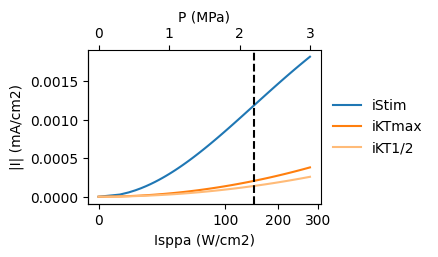

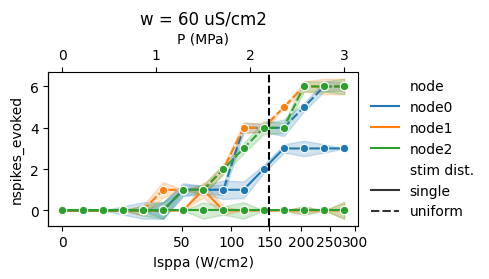

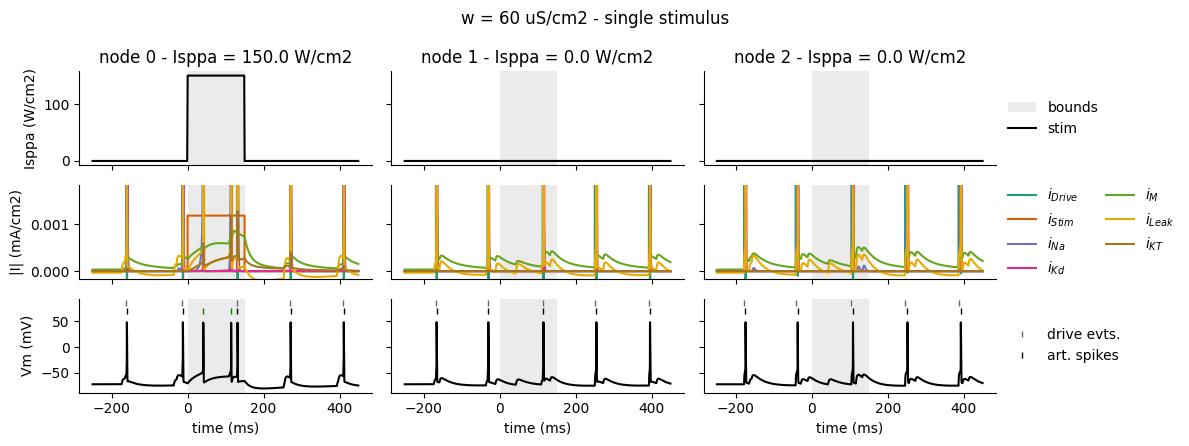

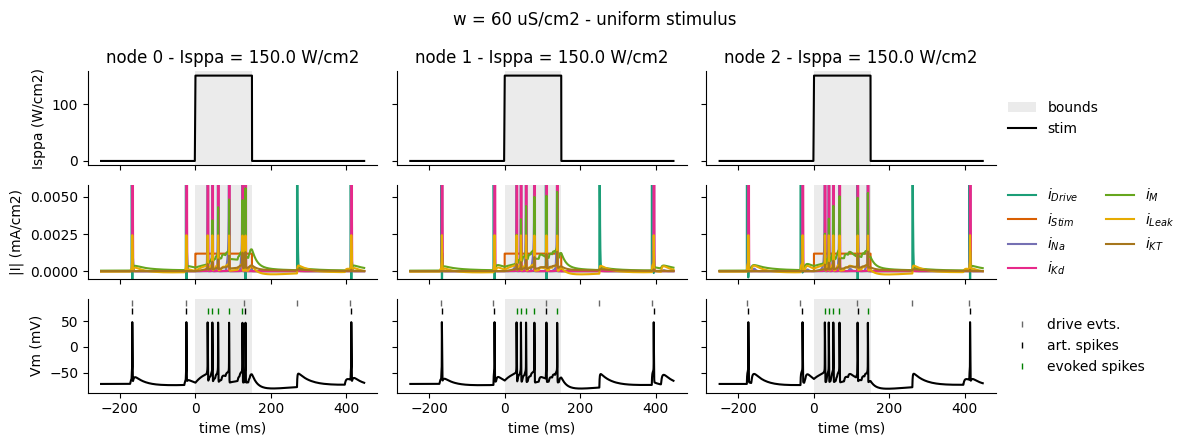

In [6]:
# Set synaptic weight
model.set_synaptic_weight(6e-5)

# Set stimulus
model.set_stim(Iref, start=start, dur=dur)

# Set stimulus sensitivity parameters
model.set_mech_param(
    iStimbar=3e-3,  # mA/cm2
    iStimdx=300,  # W/cm2
)

refaxes = []

# Plot E/I currents imbalance over stimulus intensity range
fig = model.plot_EI_imbalance(Imax, xscale='sqrt')
refaxes.append(fig.axes[0])

# Plot comparative responses over Isppa sweep for single- vs multi-node stimulation
metric = model.run_comparative_sweep(Isppa_range, 'nspikes_evoked', nreps=5)
fig = model.plot_sweep_results(metric, xscale='sqrt')
fig.axes[0].set_title(f'w = {model.get_synaptic_weight() * 1e6:.0f} uS/cm2')
refaxes.append(fig.axes[0])

# For each stimulus distribtion, run simulation and plot results
Isppa = 150.  # W/cm2
for ax in refaxes:
    ax.axvline(Isppa, color='k', linestyle='--')
for k, xvec in model.get_stimdists().items():
    model.set_stim(Isppa * xvec)
    data = model.simulate(tstop=tstop, nreps=1)
    fig = model.plot_results(
        data, exclude=['conductances', 'T'], #'iNa', 'iKd', 'iDrive', 'iLeak'],
        curr_polarity='rectified', clip_currents=True)
    fig.suptitle(f'w = {model.get_synaptic_weight() * 1e6:.0f} uS/cm2 - {k} stimulus')

### Evaluate impact of synaptic coupling and stimulus sensitivities on Isppa response curves

 08/12/2023 19:52:29: NeuralNetwork(3): setting all synaptic weights to 4.00e-05 S/cm2
 08/12/2023 19:52:29: NeuralNetwork(3): setting iStimbar = 0.002 on all nodes
 08/12/2023 19:52:29: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


 08/12/2023 19:52:33: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


 08/12/2023 19:52:37: NeuralNetwork(3): setting iStimbar = 0.003 on all nodes
 08/12/2023 19:52:37: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


 08/12/2023 19:52:41: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


 08/12/2023 19:52:45: NeuralNetwork(3): setting iStimbar = 0.004 on all nodes
 08/12/2023 19:52:45: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


 08/12/2023 19:52:49: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.28it/s]


 08/12/2023 19:52:54: NeuralNetwork(3): setting iStimbar = 0.005 on all nodes
 08/12/2023 19:52:54: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.29it/s]


 08/12/2023 19:52:59: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:05<00:00,  2.93it/s]


 08/12/2023 19:53:05: NeuralNetwork(3): setting iStimbar = 0.006 on all nodes
 08/12/2023 19:53:05: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


 08/12/2023 19:53:09: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:05<00:00,  2.54it/s]


 08/12/2023 19:53:16: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 08/12/2023 19:53:16: NeuralNetwork(3): setting iStimbar = 0.002 on all nodes
 08/12/2023 19:53:16: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:03<00:00,  3.96it/s]


 08/12/2023 19:53:20: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.34it/s]


 08/12/2023 19:53:25: NeuralNetwork(3): setting iStimbar = 0.003 on all nodes
 08/12/2023 19:53:25: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


 08/12/2023 19:53:29: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.32it/s]


 08/12/2023 19:53:34: NeuralNetwork(3): setting iStimbar = 0.004 on all nodes
 08/12/2023 19:53:34: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


 08/12/2023 19:53:39: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


 08/12/2023 19:53:44: NeuralNetwork(3): setting iStimbar = 0.005 on all nodes
 08/12/2023 19:53:44: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.57it/s]


 08/12/2023 19:53:49: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


 08/12/2023 19:53:55: NeuralNetwork(3): setting iStimbar = 0.006 on all nodes
 08/12/2023 19:53:55: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.39it/s]


 08/12/2023 19:54:00: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


 08/12/2023 19:54:07: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 08/12/2023 19:54:07: NeuralNetwork(3): setting iStimbar = 0.002 on all nodes
 08/12/2023 19:54:07: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:05<00:00,  2.70it/s]


 08/12/2023 19:54:13: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


 08/12/2023 19:54:20: NeuralNetwork(3): setting iStimbar = 0.003 on all nodes
 08/12/2023 19:54:20: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


 08/12/2023 19:54:26: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


 08/12/2023 19:54:34: NeuralNetwork(3): setting iStimbar = 0.004 on all nodes
 08/12/2023 19:54:34: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


 08/12/2023 19:54:40: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


 08/12/2023 19:54:49: NeuralNetwork(3): setting iStimbar = 0.005 on all nodes
 08/12/2023 19:54:49: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


 08/12/2023 19:54:56: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


 08/12/2023 19:55:05: NeuralNetwork(3): setting iStimbar = 0.006 on all nodes
 08/12/2023 19:55:05: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


 08/12/2023 19:55:12: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


 08/12/2023 19:55:22: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 08/12/2023 19:55:22: NeuralNetwork(3): setting iStimbar = 0.002 on all nodes
 08/12/2023 19:55:22: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


 08/12/2023 19:55:32: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


 08/12/2023 19:55:43: NeuralNetwork(3): setting iStimbar = 0.003 on all nodes
 08/12/2023 19:55:43: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


 08/12/2023 19:55:54: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


 08/12/2023 19:56:06: NeuralNetwork(3): setting iStimbar = 0.004 on all nodes
 08/12/2023 19:56:06: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


 08/12/2023 19:56:17: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


 08/12/2023 19:56:30: NeuralNetwork(3): setting iStimbar = 0.005 on all nodes
 08/12/2023 19:56:30: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


 08/12/2023 19:56:42: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


 08/12/2023 19:56:56: NeuralNetwork(3): setting iStimbar = 0.006 on all nodes
 08/12/2023 19:56:56: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


 08/12/2023 19:57:08: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


 08/12/2023 19:57:23: plotting Isppa dependencies...


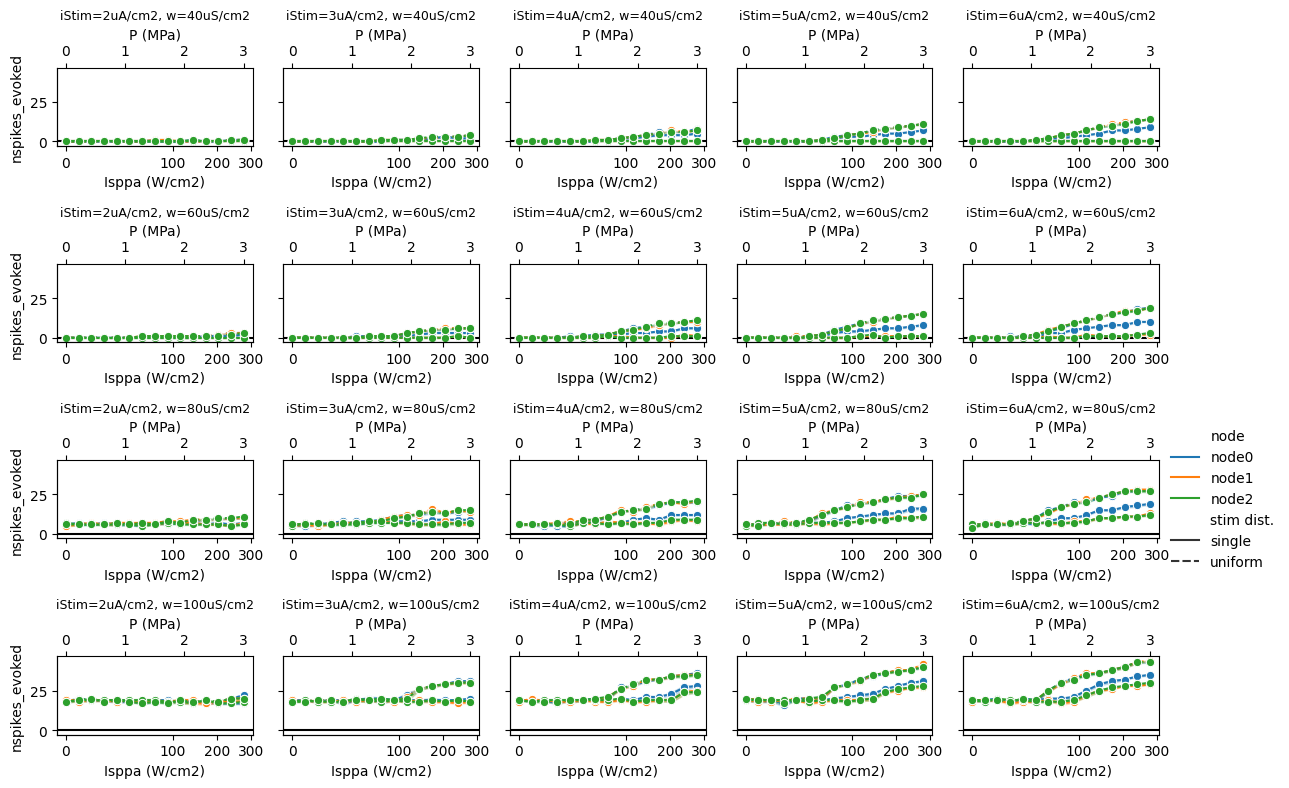

In [7]:
# Define vector of synaptic weights (in S/cm2)
wrange = np.array([4, 6, 8, 10]) * 1e-5  # S/cm2

# Define range of stimulus intensities to sweep
iStimbar_range = np.array([2, 3, 4, 5, 6]) * 1e-3  # mA/cm2

# Initialize metric container
metric = []

# For each synaptic weight value
for w in wrange:
    # Set synaptic weight parameter
    model.set_synaptic_weight(w)
    
    # For each stimulus sensitivity value
    for iStimbar in iStimbar_range:
        # Set stimulus sensitivity parameter
        model.set_mech_param(iStimbar=iStimbar)

        # Run comparative Isppa sweep for each stimulus distribution, compute metric
        # and append to container
        metric.append(
            model.run_comparative_sweep(Isppa_range, 'nspikes_evoked', nreps=5))

# Concatenate results
metric = model.concatenate_outputs(
    list(itertools.product(wrange * 1e6, iStimbar_range * 1e3)), 
    metric, 
    ['w (uS/cm2)', 'iStimbar (uA/cm2)']
)

# Plot Isppa dependencies
logger.info('plotting Isppa dependencies...')
fg = sns.FacetGrid(
    metric.reset_index(),
    col='iStimbar (uA/cm2)',
    row='w (uS/cm2)',
    aspect=1.3,
    height=2,
    sharex=False,
)
fg.set_titles('iStim={col_name:.0f}uA/cm2, w={row_name:.0f}uS/cm2')
fg.refline(y=0, linestyle='-', color='k', zorder=-1)
for iw, w in enumerate(wrange):
    for ix, iStimbar in enumerate(iStimbar_range):
        model.plot_sweep_results(
            metric.loc[w * 1e6, iStimbar * 1e3],
            ax=fg.axes[iw, ix], 
            legend=iw == wrange.size // 2 and ix == iStimbar_range.size - 1,
            xscale='sqrt')
fig = fg.figure
fig.tight_layout()
for ax in fig.axes:
    ax.set_title(ax.get_title(), fontsize=9)

### Replicate comparisons without baseline drive

 09/12/2023 17:27:46: plotting Isppa dependencies...


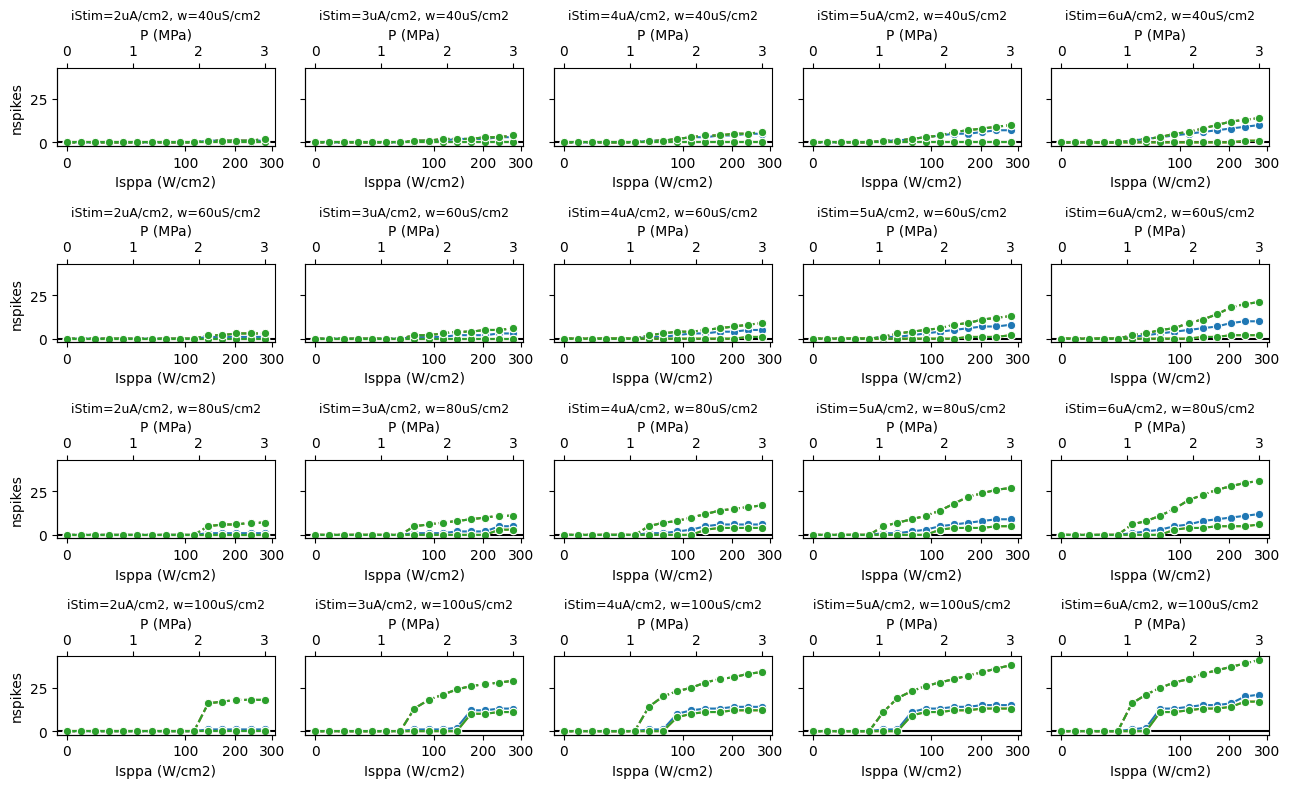

In [25]:
# # Remove baseline pre-synaptic drive
# model.remove_presyn_drive()

# # Initialize metric container
# metric = []

# # For each synaptic weight value
# for w in wrange:
#     # Set synaptic weight parameter
#     model.set_synaptic_weight(w)
    
#     # For each stimulus sensitivity value
#     for iStimbar in iStimbar_range:
#         # Set stimulus sensitivity parameter
#         model.set_mech_param(iStimbar=iStimbar)

#         # Run comparative Isppa sweep for each stimulus distribution, compute metric
#         # and append to container
#         metric.append(
#             model.run_comparative_sweep(Isppa_range, 'nspikes', nreps=1))

# # Concatenate results
# metric = model.concatenate_outputs(
#     list(itertools.product(wrange * 1e6, iStimbar_range * 1e3)), 
#     metric, 
#     ['w (uS/cm2)', 'iStimbar (uA/cm2)']
# )

# Plot Isppa dependencies
logger.info('plotting Isppa dependencies...')
fg = sns.FacetGrid(
    metric.reset_index(),
    col='iStimbar (uA/cm2)',
    row='w (uS/cm2)',
    aspect=1.3,
    height=2,
    sharex=False,
)
fg.set_titles('iStim={col_name:.0f}uA/cm2, w={row_name:.0f}uS/cm2')
for iw, w in enumerate(wrange):
    for ix, iStimbar in enumerate(iStimbar_range):
        model.plot_sweep_results(
            metric.loc[w * 1e6, iStimbar * 1e3],
            ax=fg.axes[iw, ix], 
            legend=iw == wrange.size // 2 and ix == iStimbar_range.size - 1,
            xscale='sqrt',
        )
fg.refline(y=0, linestyle='-', color='k', zorder=-1)
fig = fg.figure
fig.tight_layout()
for ax in fig.axes:
    ax.set_title(ax.get_title(), fontsize=9)

 09/12/2023 11:52:54: NeuralNetwork(3): setting pre-synaptic drive on nodes [0, 1, 2]
 09/12/2023 11:52:54: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 70.2 ms
 09/12/2023 11:52:54: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 72.5 ms
 09/12/2023 11:52:54: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 69.0 ms
 09/12/2023 11:52:54: NeuralNetwork(3): setting iStimbar = 0.003 on all nodes
 09/12/2023 11:52:54: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 09/12/2023 11:52:54: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.46it/s]

 09/12/2023 11:52:57: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  5.87it/s]


Text(0.5, 1.0, 'iStimbar = 3 uA/cm2, w = 100 uS/cm2')

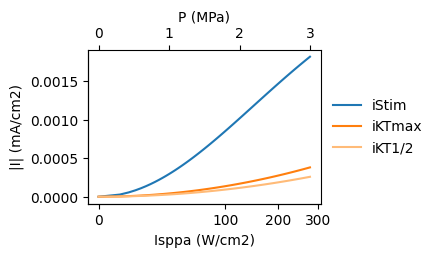

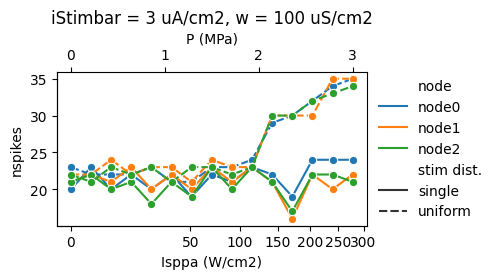

In [9]:
# Set pre-synaptic drive
model.set_presyn_drive(freq=drive_freq, noise=noise)

# Set stimulus sensitivity and synaptic weight
model.set_mech_param(
    iStimbar=3e-3,  # mA/cm2
    iStimdx=300,  # W/cm2
)
model.set_synaptic_weight(10e-5)

# Plot E/I currents imbalance over stimulus intensity range
fig = model.plot_EI_imbalance(Imax, xscale='sqrt')

# # Run comparative Isppa sweep ror each stimulus distribution
metric2 = model.run_comparative_sweep(Isppa_range, 'nspikes', nreps=1)

# Plot Isppa dependencies
fig = model.plot_sweep_results(metric2, xscale='sqrt')
ax = fig.axes[0]
ax.set_title(
    f'iStimbar = {model.iStimbar * 1e3:.0f} uA/cm2, w = {model.get_synaptic_weight() * 1e6:.0f} uS/cm2')

 07/12/2023 22:13:24: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 07/12/2023 22:13:24: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [01:12<00:00,  4.83s/it]


 07/12/2023 22:14:39: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [01:13<00:00,  4.91s/it]


Text(0.5, 1.2, 'w = 8.00e-05 S/cm2')

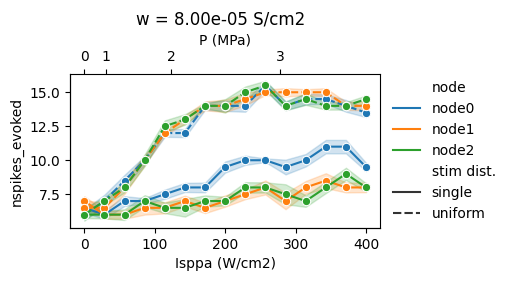

In [30]:
sweepdata = []
model.set_synaptic_weight(8e-5)
tmprange = np.linspace(0, 400, 15)
# For each stimulus distribution
for k, xvec in dists.items():
    # Run sweep over stimulus intensities, and append results to list
    sweepdata.append(model.run_stim_sweep(tmprange, stimdist=xvec, nreps=10))
# Concatenate results
sweepdata = model.concatenate_outputs(dists.keys(), sweepdata, 'stim dist.')
fig = model.plot_sweep_results(sweepdata, 'nspikes_evoked')
fig.suptitle(f'w = {model.get_synaptic_weight():.2e} S/cm2', y=1.2)

 07/12/2023 22:26:56: NeuralNetwork(3): setting all synaptic weights to 7.00e-05 S/cm2
 07/12/2023 22:26:56: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [03:34<00:00, 14.31s/it]


 07/12/2023 22:30:44: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [03:40<00:00, 14.68s/it]


Text(0.5, 1.2, 'w = 7.00e-05 S/cm2')

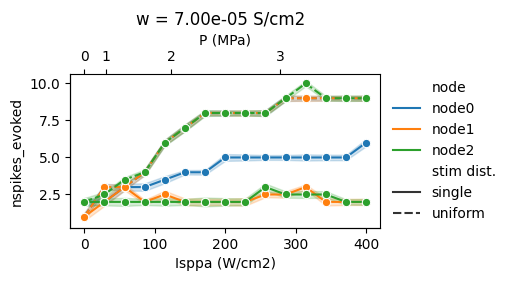

In [32]:
sweepdata = []
model.set_synaptic_weight(7e-5)
tmprange = np.linspace(0, 400, 15)
# For each stimulus distribution
for k, xvec in dists.items():
    # Run sweep over stimulus intensities, and append results to list
    sweepdata.append(model.run_stim_sweep(tmprange, stimdist=xvec, nreps=30))
# Concatenate results
sweepdata = model.concatenate_outputs(dists.keys(), sweepdata, 'stim dist.')
fig = model.plot_sweep_results(sweepdata, 'nspikes_evoked')
fig.suptitle(f'w = {model.get_synaptic_weight():.2e} S/cm2', y=1.2)

 07/12/2023 22:05:35: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 07/12/2023 22:05:35: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 10.0 W/cm2
    - node 1: 0.0 W/cm2
    - node 2: 0.0 W/cm2
 07/12/2023 22:05:35: NeuralNetwork(3): setting start time of pre-synaptic drive 0 to 72.80 ms...
 07/12/2023 22:05:35: NeuralNetwork(3): setting start time of pre-synaptic drive 1 to 68.45 ms...
 07/12/2023 22:05:35: NeuralNetwork(3): setting start time of pre-synaptic drive 2 to 73.95 ms...
 07/12/2023 22:05:35: NeuralNetwork(3): disabled currents: iNaKPump
 07/12/2023 22:05:35: NeuralNetwork(3): simulating for 700.00 ms
 07/12/2023 22:05:35: NeuralNetwork(3): extracting output results
 07/12/2023 22:05:36: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.1 °C
    - node 1: ΔT = 0.0 °C
    - node 2: ΔT = 0.0 °C
 07/12/2023 22:05:36: NeuralNetwork(3): number of spikes:
    - node 0: n = 9 spikes
    - node 1: n = 9 

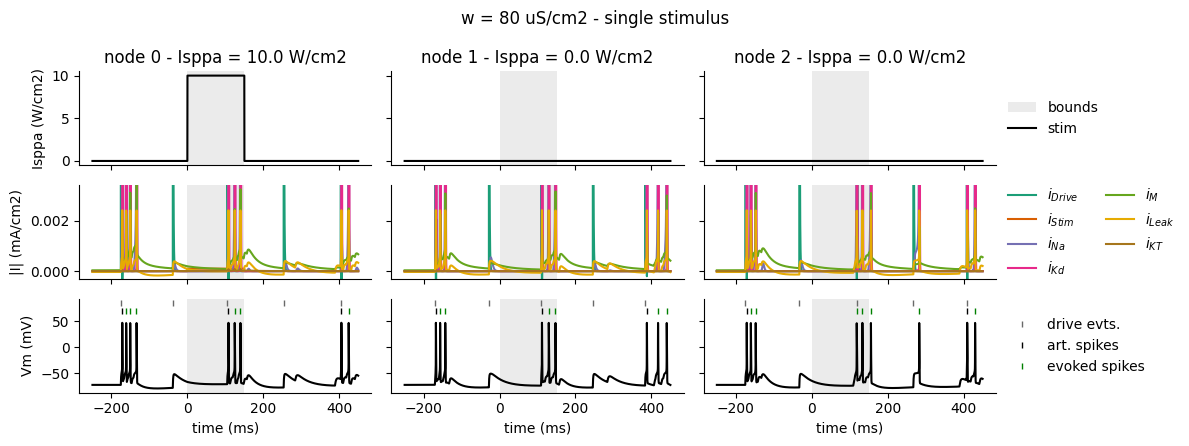

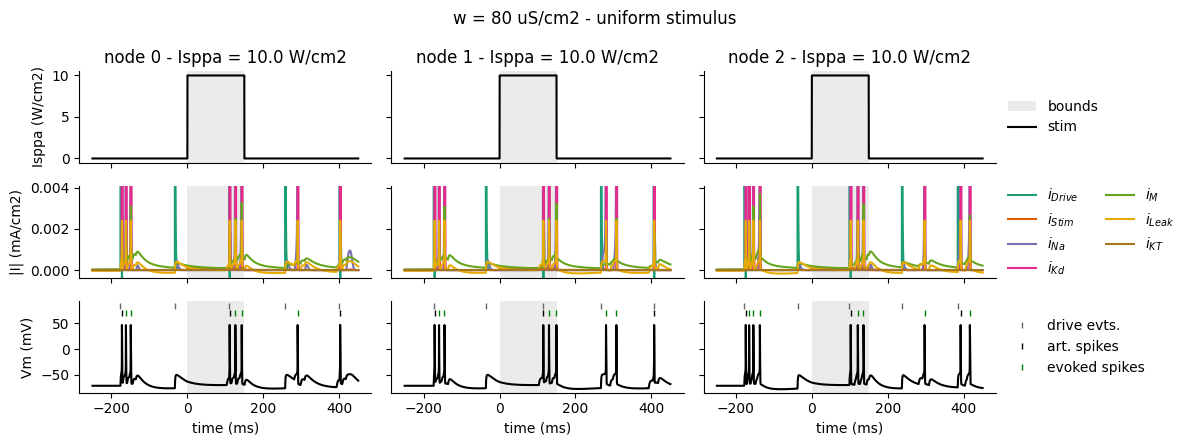

In [28]:
model.verbose = True
# For each stimulus distribtion, run simulation and plot results
model.set_synaptic_weight(8e-5)
Isppa = 10.  # W/cm2
for k, xvec in dists.items():
    model.set_stim(Isppa * xvec)
    data = model.simulate(tstop=tstop, nreps=1)
    fig = model.plot_results(
        data, exclude=['conductances', 'T'], #'iNa', 'iKd', 'iDrive', 'iLeak'],
        curr_polarity='rectified', clip_currents=True)
    fig.suptitle(f'w = {model.get_synaptic_weight() * 1e6:.0f} uS/cm2 - {k} stimulus')

### Inpsect combined impact of stimulus sensitivity and coupling strength on spiking activity

In [7]:
# # Define vector of coupling strengths (in S/cm2)
# wrange = np.linspace(1, 4, 10) * model.g_RS_RS

# # Define vector of stimulus sensitivities (in mA/W)
# Ɣrange = np.array([4e-6, 1e-5, 2e-5])

# # For each stimulus sensitivity
# nreps = 3
# data = []
# for Ɣ in Ɣrange:
#     model.set_mech_param(gamma=Ɣ)

#     # Run simulation for each coupling strength
#     model.verbose = False
#     for w in tqdm(wrange):
#         model.set_synaptic_weight(w)
#         data.append(model.simulate(nreps=nreps))
#     model.verbose = True

# # Concatenate results
# data = pd.concat(
#     data, 
#     keys=list(itertools.product(Ɣrange, wrange)), 
#     names=['Ɣ (S/cm2)', 'w (S/cm2)'])

# # Plot dependency of evoked firing rate on coupling strength
# model.plot_sweep_results(data, 'nspikes')

# # Set parameters to enable strong evoked response without tonic firing
# model.set_mech_param(gamma=2e-5)
# model.set_synaptic_weight(5e-5)

# # Run simulation and plot results
# data = model.simulate()
# fig = model.plot_results(data, exclude=['conductances', 'iNa', 'iKd', 'iLeak', 'iDrive'])

# # Reset gamma and synaptic weight to their default values
# model.set_mech_param(gamma=params['gamma'])
# model.set_synaptic_weight(model.g_RS_RS)

### Inpspect combined impact of stimulus sensitivity and coupling strength on stimulus-evoked responses, across Isppa range

In [8]:
# # Define vector of coupling strengths (in S/cm2)
# wrange = np.linspace(1, 4, 3) * model.g_RS_RS

# # Define vector of stimulus sensitivities (in mA/W)
# iStim_Ɣrange = np.array([4e-6, 1e-5, 2e-5])

# # Define vector of stimulus intensities (in W/cm2)
# Isppa_range = np.linspace(0, 300, 10)

# # For each stimulus sensitivity
# nreps = 3
# data, keys = [], []
# for Ɣ in Ɣrange:
#     model.set_mech_param(gamma=Ɣ)
#     # For each coupling strength
#     for w in wrange:
#         model.set_synaptic_weight(w)
#         # Run sweep over stimulus intensities, and plot results
#         data.append(model.run_stim_sweep(Isppa_range, nreps=nreps))
#         keys.append((Ɣ, w))

# # Concatenate results
# data = pd.concat(data, keys=keys, names=['Ɣ (mA/W)', 'w (S/cm2)'])

# # Reset gamma and synaptic weight to their default values
# model.set_mech_param(gamma=params['gamma'])
# model.set_synaptic_weight(model.g_RS_RS)

# # Plot results
# logger.info('plotting results...')
# fg = sns.FacetGrid(
#     data.reset_index(),
#     col='Ɣ (mA/W)',
#     row='w (S/cm2)',
#     aspect=1.5,
#     height=2,
# )
# fg.set_titles('Ɣ = {col_name:.1e} mA/W, w = {row_name:.1e} S/cm2')
# for iw, w in enumerate(wrange):
#     for ig, Ɣ in enumerate(Ɣrange):
#         gdata = data.loc[Ɣ, w]
#         model.plot_sweep_results(
#             gdata, 'nspikes', ax=fg.axes[iw, ig], legend=iw == 1 and ig == 2)
# fig = fg.figure

 07/12/2023 15:55:53: NeuralNetwork(3): setting iStimbar = 0.006 on all nodes
 07/12/2023 15:55:53: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 07/12/2023 15:55:53: NeuralNetwork(3): running simulation sweep across 20 stimulus intensities


100%|██████████| 20/20 [00:55<00:00,  2.77s/it]


 07/12/2023 15:56:50: NeuralNetwork(3): running simulation sweep across 20 stimulus intensities


100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


 07/12/2023 15:58:07: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 07/12/2023 15:58:07: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 30.9 W/cm2
    - node 1: 30.9 W/cm2
    - node 2: 30.9 W/cm2


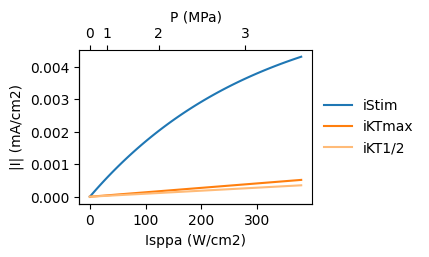

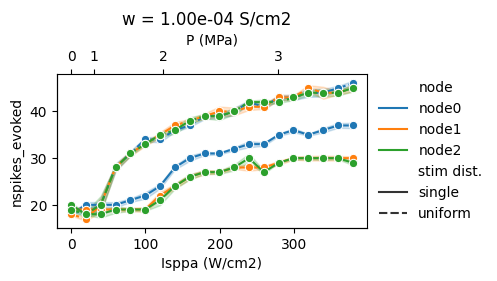

In [91]:
# Set stimulus sensitivity and synaptic weight
model.set_mech_param(
    iStimbar=6e-3,  # mA/cm2
    iStimdx=300,  # W/cm2
)

# Plot E/I currents imbalance over stimulus intensity range
fig = model.plot_EI_imbalance(Imax)

# Define range of synaptic weights (in S/cm2)
wrange = [10e-5]

for w in wrange:
    model.set_synaptic_weight(w)
    data = []
    # For each stimulus distribution
    for k, xvec in dists.items():
        # Run sweep over stimulus intensities, and append results to list
        data.append(model.run_stim_sweep(Isppa_range_dense, stimdist=xvec, nreps=5))
    # Concatenate results
    data = model.concatenate_outputs(dists.keys(), data, 'stim dist.')
    fig = model.plot_sweep_results(data, 'nspikes_evoked')
    fig.suptitle(f'w = {model.get_synaptic_weight():.2e} S/cm2', y=1.2)

# Reset stimulus amplitude and synaptic weight to reference value
model.set_synaptic_weight(model.g_RS_RS)
model.set_stim(Iref)

 07/12/2023 17:33:15: no pre-synaptic drive to remove at node 0
 07/12/2023 17:33:15: no pre-synaptic drive to remove at node 1
 07/12/2023 17:33:15: no pre-synaptic drive to remove at node 2


100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


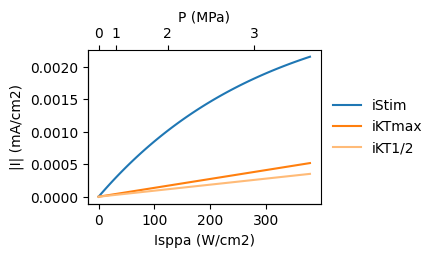

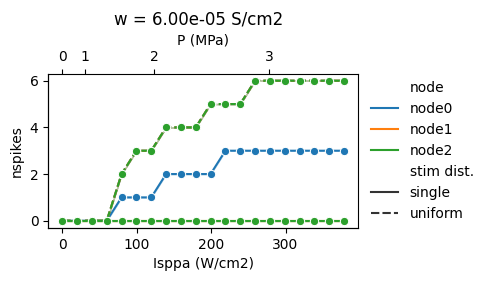

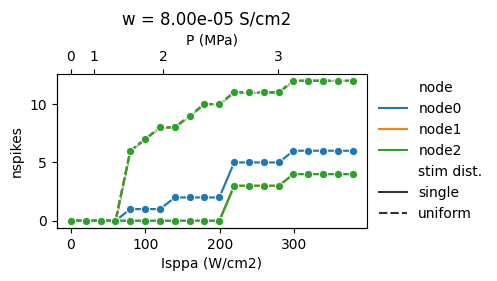

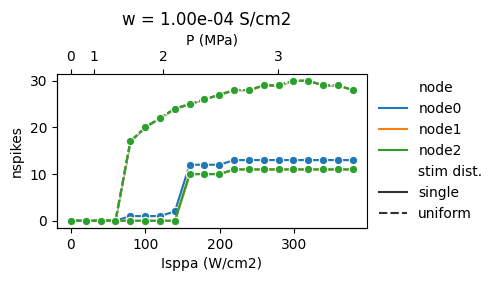

In [103]:
# Set stimulus sensitivity and synaptic weight
model.set_mech_param(
    iStimbar=3e-3,  # mA/cm2
    iStimdx=300,  # W/cm2
)

model.remove_presyn_drive()
# model.set_presyn_drive(freq=drive_freq, noise=noise)

# Plot E/I currents imbalance over stimulus intensity range
fig = model.plot_EI_imbalance(Imax)

# Define vector of stimulus intensities per node (in W/cm2) for both 
# single and multi-node stimulation
dists = {k: model.get_stimdist_vector(kind=k) for k in ['single', 'uniform']}

# Define dense vector of stimulus intensities (in W/cm2)
Isppa_range_dense = np.linspace(0, Imax, 20)

# Define range of synaptic weights (in S/cm2)
wrange = np.array([6, 8, 10]) * 1e-5

for w in wrange:
    model.set_synaptic_weight(w)
    data = []
    # For each stimulus distribution
    for k, xvec in dists.items():
        # Run sweep over stimulus intensities, and append results to list
        data.append(model.run_stim_sweep(Isppa_range_dense, stimdist=xvec, nreps=5))
    # Concatenate results
    data = model.concatenate_outputs(dists.keys(), data, 'stim dist.')
    fig = model.plot_sweep_results(data, 'nspikes')
    fig.suptitle(f'w = {model.get_synaptic_weight():.2e} S/cm2', y=1.2)

# Reset stimulus amplitude and synaptic weight to reference value
model.set_synaptic_weight(model.g_RS_RS)
model.set_stim(Iref)

 07/12/2023 18:05:23: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 07/12/2023 18:05:23: NeuralNetwork(3): setting pre-synaptic drive on nodes [0, 1, 2]
 07/12/2023 18:05:23: modifying pre-synaptic drive on node 0
 07/12/2023 18:05:23: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 71.9 ms
 07/12/2023 18:05:23: modifying pre-synaptic drive on node 1
 07/12/2023 18:05:23: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 70.0 ms
 07/12/2023 18:05:23: modifying pre-synaptic drive on node 2
 07/12/2023 18:05:23: creating 7.0 ± 0.4 Hz pre-synaptic drive starting at 72.1 ms
 07/12/2023 18:05:23: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 100.0 W/cm2
    - node 1: 0.0 W/cm2
    - node 2: 0.0 W/cm2
 07/12/2023 18:05:23: NeuralNetwork(3): setting start time of pre-synaptic drive 0 to 74.44 ms...
 07/12/2023 18:05:23: NeuralNetwork(3): setting start time of pre-synaptic drive 1 to 73.63 ms...
 07/12/2023 18:05:23: Neura

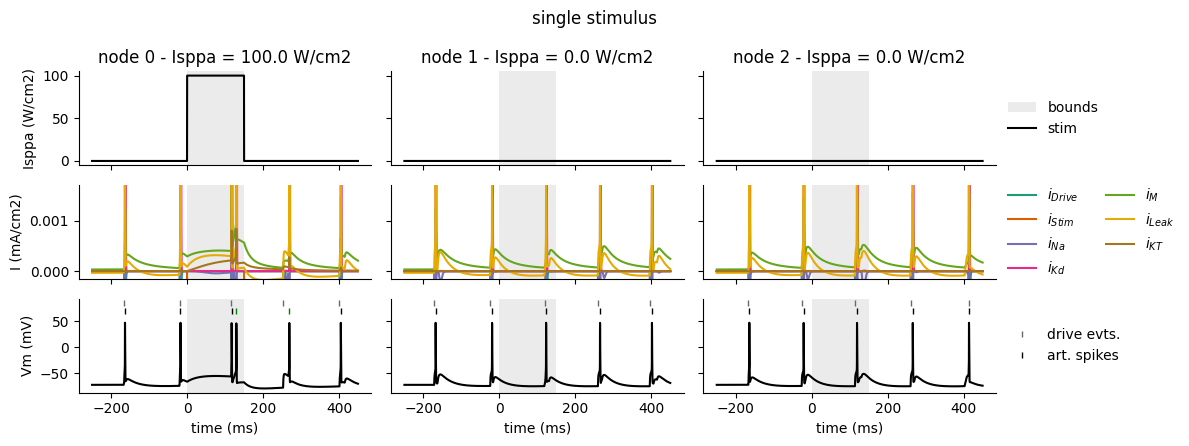

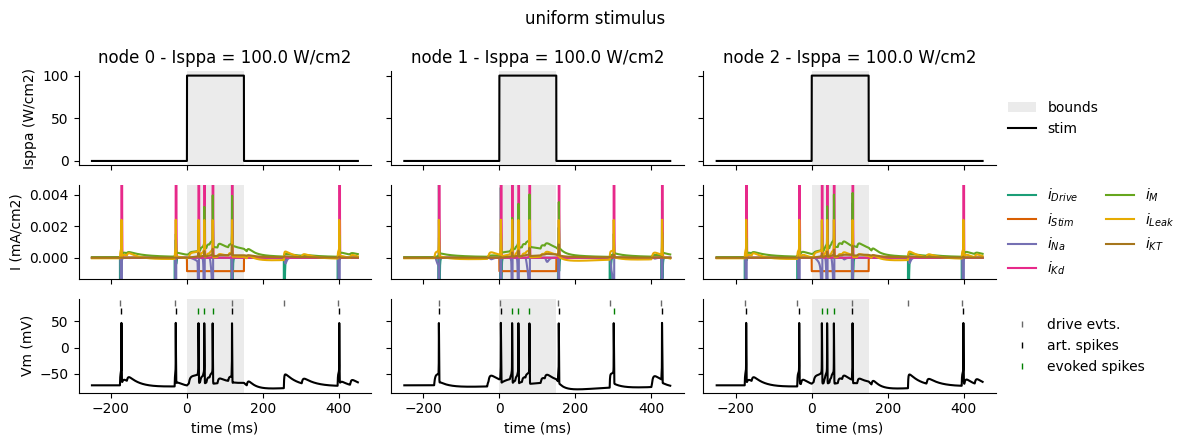

In [112]:
model.set_synaptic_weight(.6e-4)
model.set_presyn_drive(freq=drive_freq, noise=noise)
# For each stimulus distribution
Isppa = 100.
for k, xvec in dists.items():
    model.set_stim(Isppa * xvec)
    data = model.simulate()
    fig = model.plot_results(data, exclude=['conductances', 'T'], clip_currents=True)
    fig.suptitle(f'{k} stimulus')

### Inspect Isppa dependency curves for single-node vs multi-node stimulation

 03/12/2023 19:32:53: NeuralNetwork(3): setting iStimbar = 0.0002 on all nodes
 03/12/2023 19:32:53: NeuralNetwork(3): setting iStimx0 = 50.0 on all nodes
 03/12/2023 19:32:53: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:32:53: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


 03/12/2023 19:32:58: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


 03/12/2023 19:33:03: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 19:33:03: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


 03/12/2023 19:33:08: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


 03/12/2023 19:33:13: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 03/12/2023 19:33:13: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


 03/12/2023 19:33:18: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

 03/12/2023 19:33:22: NeuralNetwork(3): setting iStimx0 = 200.0 on all nodes
 03/12/2023 19:33:22: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:33:22: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

 03/12/2023 19:33:27: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

 03/12/2023 19:33:31: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 19:33:31: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.36it/s]

 03/12/2023 19:33:35: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

 03/12/2023 19:33:40: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 03/12/2023 19:33:40: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

 03/12/2023 19:33:44: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

 03/12/2023 19:33:49: NeuralNetwork(3): setting iStimx0 = 350.0 on all nodes
 03/12/2023 19:33:49: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:33:49: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

 03/12/2023 19:33:53: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

 03/12/2023 19:33:57: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 19:33:57: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.41it/s]

 03/12/2023 19:34:02: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

 03/12/2023 19:34:06: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 03/12/2023 19:34:06: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

 03/12/2023 19:34:11: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


 03/12/2023 19:34:18: NeuralNetwork(3): setting iStimx0 = 180 on all nodes
 03/12/2023 19:34:18: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:34:18: plotting results...
 03/12/2023 19:34:32: NeuralNetwork(3): setting iStimbar = 0.0006 on all nodes
 03/12/2023 19:34:32: NeuralNetwork(3): setting iStimx0 = 50.0 on all nodes
 03/12/2023 19:34:32: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:34:32: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


 03/12/2023 19:34:37: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


 03/12/2023 19:34:42: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 19:34:42: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

 03/12/2023 19:34:46: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


 03/12/2023 19:34:51: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 03/12/2023 19:34:51: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


 03/12/2023 19:34:55: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


 03/12/2023 19:35:00: NeuralNetwork(3): setting iStimx0 = 200.0 on all nodes
 03/12/2023 19:35:00: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:35:00: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


 03/12/2023 19:35:04: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

 03/12/2023 19:35:09: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 19:35:09: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


 03/12/2023 19:35:13: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

 03/12/2023 19:35:18: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 03/12/2023 19:35:18: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

 03/12/2023 19:35:22: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

 03/12/2023 19:35:26: NeuralNetwork(3): setting iStimx0 = 350.0 on all nodes
 03/12/2023 19:35:26: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:35:26: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

 03/12/2023 19:35:31: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

 03/12/2023 19:35:35: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 19:35:35: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

 03/12/2023 19:35:40: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

 03/12/2023 19:35:44: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 03/12/2023 19:35:44: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

 03/12/2023 19:35:49: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


 03/12/2023 19:35:58: NeuralNetwork(3): setting iStimx0 = 180 on all nodes
 03/12/2023 19:35:58: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:35:58: plotting results...
 03/12/2023 19:36:16: NeuralNetwork(3): setting iStimbar = 0.001 on all nodes
 03/12/2023 19:36:16: NeuralNetwork(3): setting iStimx0 = 50.0 on all nodes
 03/12/2023 19:36:16: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:36:16: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


 03/12/2023 19:36:21: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


 03/12/2023 19:36:26: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 19:36:26: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


 03/12/2023 19:36:31: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

 03/12/2023 19:36:35: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 03/12/2023 19:36:35: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

 03/12/2023 19:36:40: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


 03/12/2023 19:36:44: NeuralNetwork(3): setting iStimx0 = 200.0 on all nodes
 03/12/2023 19:36:44: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:36:44: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.35it/s]

 03/12/2023 19:36:49: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


 03/12/2023 19:36:53: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 19:36:53: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


 03/12/2023 19:36:58: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


 03/12/2023 19:37:03: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 03/12/2023 19:37:03: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:04<00:00,  2.34it/s]

 03/12/2023 19:37:07: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

 03/12/2023 19:37:12: NeuralNetwork(3): setting iStimx0 = 350.0 on all nodes
 03/12/2023 19:37:12: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:37:12: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

 03/12/2023 19:37:16: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

 03/12/2023 19:37:21: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 19:37:21: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

 03/12/2023 19:37:25: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

 03/12/2023 19:37:30: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 03/12/2023 19:37:30: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.27it/s]

 03/12/2023 19:37:34: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities



100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


 03/12/2023 19:37:42: NeuralNetwork(3): setting iStimx0 = 180 on all nodes
 03/12/2023 19:37:42: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 19:37:42: plotting results...
 03/12/2023 19:37:55: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 30.9 W/cm2
    - node 1: 30.9 W/cm2
    - node 2: 30.9 W/cm2


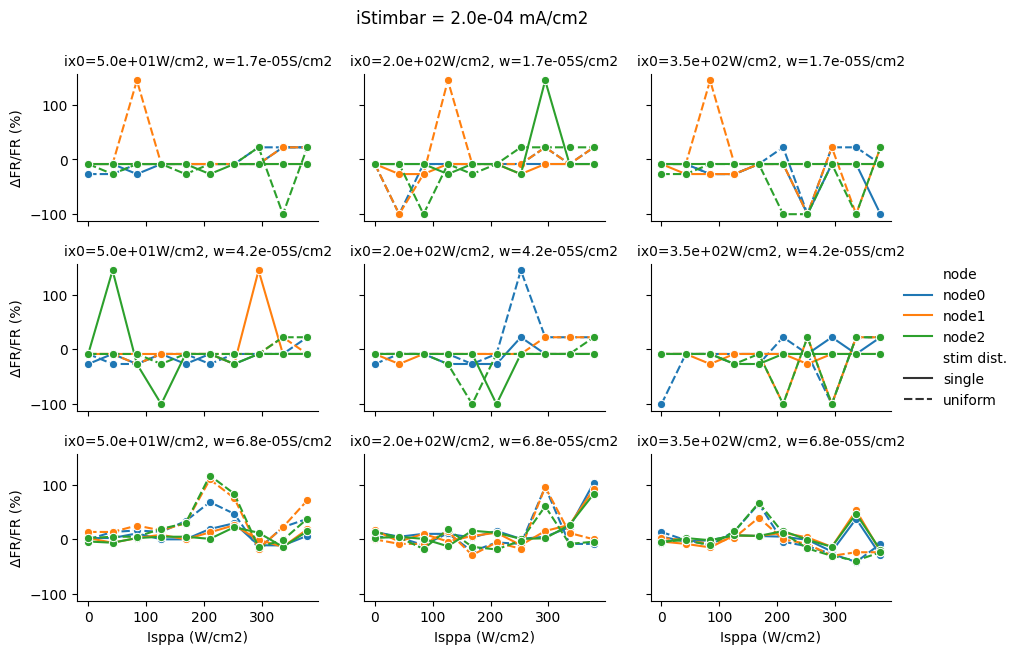

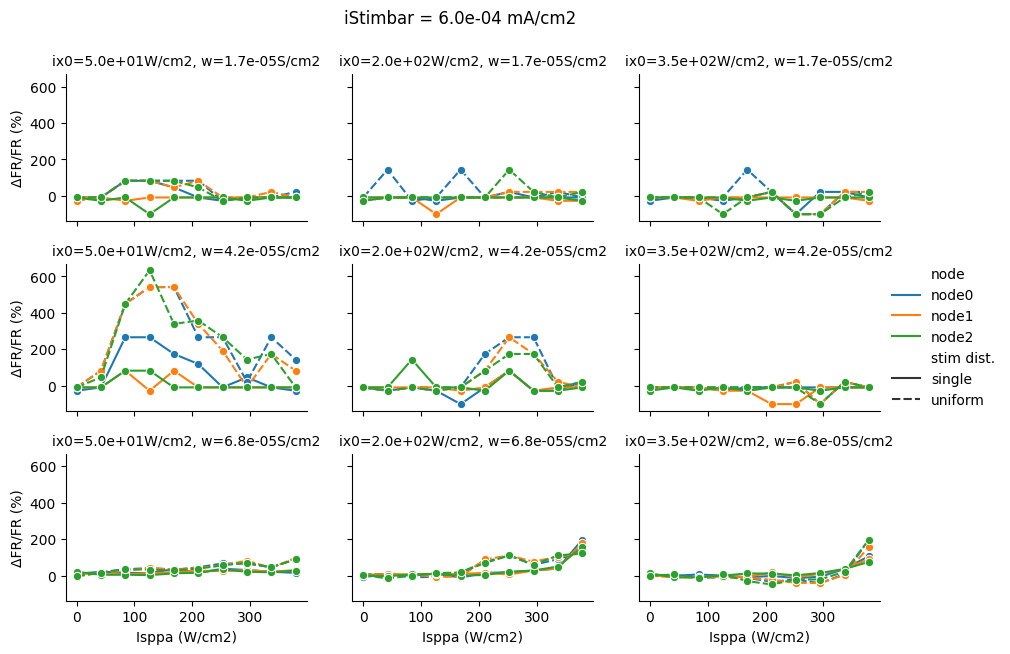

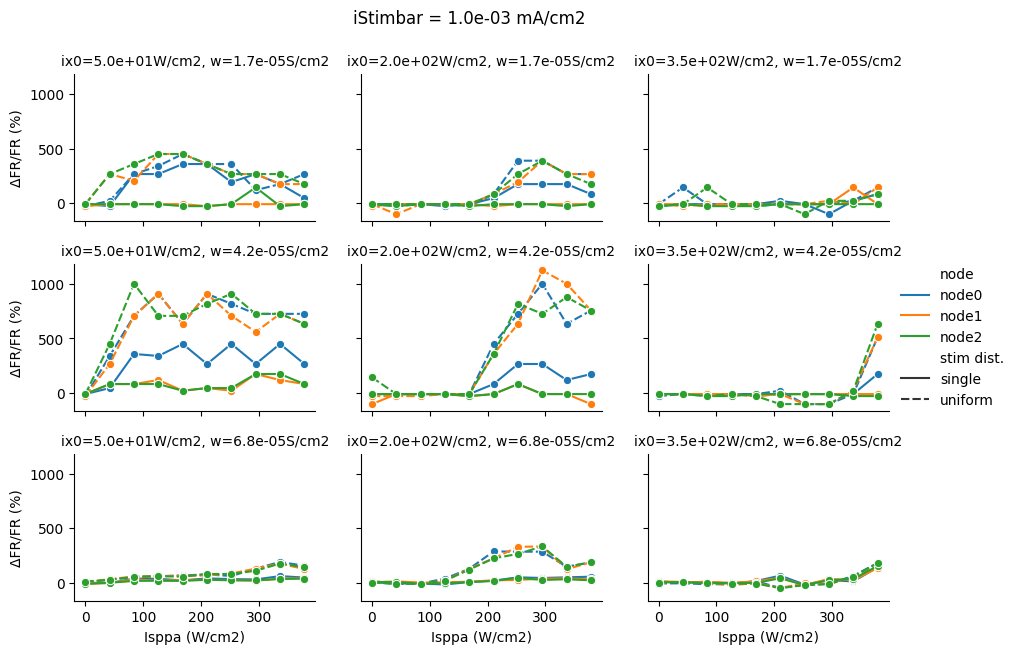

In [12]:
# Define vector of coupling strengths (in S/cm2)
wrange = np.array([1, 2.5, 4]) * model.g_RS_RS
iStimx0_range = np.linspace(50, 350, 3)  # W/cm2
iStimbar_range = np.linspace(2e-4, 1e-3, 3).round(4)  # mA/cm2

# For each stimulus sensitivity
for iStimbar in iStimbar_range:
    # Set maximum stim-driven current amplitude to current value
    model.set_mech_param(iStimbar=iStimbar)

    # For each stimulus sensitivity
    data, keys = [], []
    for iStimx0 in iStimx0_range:
        model.set_mech_param(iStimx0=iStimx0)
        # For each coupling strength
        for w in wrange:
            model.set_synaptic_weight(w)
            # For each stimulus distribution
            for k, xvec in dists.items():
                # Run sweep over stimulus intensities, and append results to list
                data.append(model.run_stim_sweep(Isppa_range, stimdist=xvec, nreps=nreps))
                keys.append((iStimx0, w, k))

    # Concatenate results
    data = pd.concat(data, keys=keys, names=['iStimx0 (W/cm2)', 'w (S/cm2)', 'stim dist.'])

    # Reset gamma and synaptic weight to their default values
    model.set_mech_param(iStimx0=params['iStimx0'])
    model.set_synaptic_weight(model.g_RS_RS)

    # Plot results
    logger.info('plotting results...')
    fg = sns.FacetGrid(
        data.reset_index(),
        col='iStimx0 (W/cm2)',
        row='w (S/cm2)',
        aspect=1.5,
        height=2,
    )
    fg.set_titles('ix0={col_name:.1e}W/cm2, w={row_name:.1e}S/cm2')
    for iw, w in enumerate(wrange):
        for ix, iStimx0 in enumerate(iStimx0_range):
            gdata = data.loc[iStimx0, w]
            model.plot_sweep_results(
                gdata, model.RESP_KEY, 
                ax=fg.axes[iw, ix], legend=iw == 1 and ix == 2)
    fig = fg.figure
    fig.suptitle(f'iStimbar = {iStimbar:.1e} mA/cm2', y=1.05)

# Reset maximum stim-driven current amplitude to default value
model.set_mech_param(iStimbar=params['iStimbar'])

# Reset stimulus amplitude to reference value
model.set_stim(Iref)

 03/12/2023 22:37:18: NeuralNetwork(3): setting iStimbar = 0.0002 on all nodes
 03/12/2023 22:37:18: NeuralNetwork(3): setting iStimx0 = 50.0 on all nodes
 03/12/2023 22:37:18: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 22:37:18: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


 03/12/2023 22:37:47: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


 03/12/2023 22:38:15: NeuralNetwork(3): setting iStimx0 = 200.0 on all nodes
 03/12/2023 22:38:15: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 22:38:15: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


 03/12/2023 22:38:43: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


 03/12/2023 22:39:11: NeuralNetwork(3): setting iStimx0 = 350.0 on all nodes
 03/12/2023 22:39:11: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 22:39:11: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


 03/12/2023 22:39:38: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


 03/12/2023 22:40:15: NeuralNetwork(3): setting iStimx0 = 180 on all nodes
 03/12/2023 22:40:16: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 22:40:16: plotting results...
 03/12/2023 22:41:20: NeuralNetwork(3): setting iStimbar = 0.0006 on all nodes
 03/12/2023 22:41:20: NeuralNetwork(3): setting iStimx0 = 50.0 on all nodes
 03/12/2023 22:41:20: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 22:41:20: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.80s/it]


 03/12/2023 22:41:49: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


 03/12/2023 22:42:18: NeuralNetwork(3): setting iStimx0 = 200.0 on all nodes
 03/12/2023 22:42:18: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 22:42:18: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


 03/12/2023 22:42:46: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


 03/12/2023 22:43:14: NeuralNetwork(3): setting iStimx0 = 350.0 on all nodes
 03/12/2023 22:43:14: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 22:43:14: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


 03/12/2023 22:43:42: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


 03/12/2023 22:44:20: NeuralNetwork(3): setting iStimx0 = 180 on all nodes
 03/12/2023 22:44:20: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 22:44:20: plotting results...
 03/12/2023 22:45:21: NeuralNetwork(3): setting iStimbar = 0.001 on all nodes
 03/12/2023 22:45:21: NeuralNetwork(3): setting iStimx0 = 50.0 on all nodes
 03/12/2023 22:45:21: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 22:45:21: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


 03/12/2023 22:45:49: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


 03/12/2023 22:46:18: NeuralNetwork(3): setting iStimx0 = 200.0 on all nodes
 03/12/2023 22:46:18: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 22:46:18: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


 03/12/2023 22:46:46: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.76s/it]


 03/12/2023 22:47:15: NeuralNetwork(3): setting iStimx0 = 350.0 on all nodes
 03/12/2023 22:47:15: NeuralNetwork(3): setting all synaptic weights to 4.22e-05 S/cm2
 03/12/2023 22:47:15: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.78s/it]


 03/12/2023 22:47:43: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


 03/12/2023 22:48:22: NeuralNetwork(3): setting iStimx0 = 180 on all nodes
 03/12/2023 22:48:22: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 03/12/2023 22:48:22: plotting results...
 03/12/2023 22:49:26: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 30.9 W/cm2
    - node 1: 30.9 W/cm2
    - node 2: 30.9 W/cm2


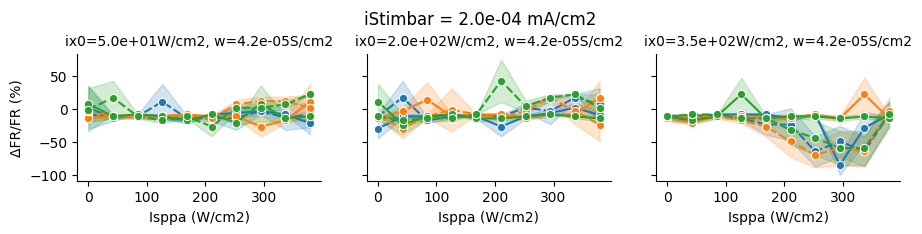

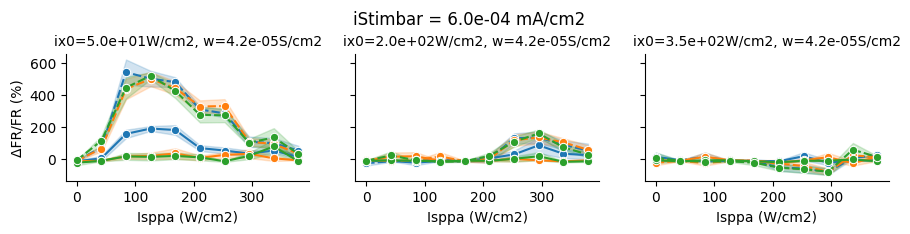

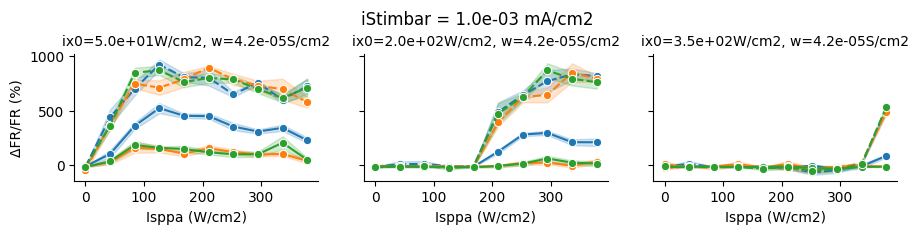

In [15]:
# Define vector of coupling strengths (in S/cm2)
wrange = np.array([2.5]) * model.g_RS_RS
iStimx0_range = np.linspace(50, 350, 3)  # W/cm2
iStimbar_range = np.linspace(2e-4, 1e-3, 3).round(4)  # mA/cm2

nreps = 6

# For each stimulus sensitivity
for iStimbar in iStimbar_range:
    # Set maximum stim-driven current amplitude to current value
    model.set_mech_param(iStimbar=iStimbar)

    # For each stimulus sensitivity
    data, keys = [], []
    for iStimx0 in iStimx0_range:
        model.set_mech_param(iStimx0=iStimx0)
        # For each coupling strength
        for w in wrange:
            model.set_synaptic_weight(w)
            # For each stimulus distribution
            for k, xvec in dists.items():
                # Run sweep over stimulus intensities, and append results to list
                data.append(model.run_stim_sweep(Isppa_range, stimdist=xvec, nreps=nreps))
                keys.append((iStimx0, w, k))

    # Concatenate results
    data = pd.concat(data, keys=keys, names=['iStimx0 (W/cm2)', 'w (S/cm2)', 'stim dist.'])

    # Reset gamma and synaptic weight to their default values
    model.set_mech_param(iStimx0=params['iStimx0'])
    model.set_synaptic_weight(model.g_RS_RS)

    # Plot results
    logger.info('plotting results...')
    fg = sns.FacetGrid(
        data.reset_index(),
        col='iStimx0 (W/cm2)',
        row='w (S/cm2)',
        aspect=1.5,
        height=2,
    )
    fg.set_titles('ix0={col_name:.1e}W/cm2, w={row_name:.1e}S/cm2')
    for iw, w in enumerate(wrange):
        for ix, iStimx0 in enumerate(iStimx0_range):
            gdata = data.loc[iStimx0, w]
            model.plot_sweep_results(
                gdata, model.RESP_KEY, 
                ax=fg.axes[iw, ix], legend=iw == 1 and ix == 2)
    fig = fg.figure
    fig.suptitle(f'iStimbar = {iStimbar:.1e} mA/cm2', y=1.05)

# Reset maximum stim-driven current amplitude to default value
model.set_mech_param(iStimbar=params['iStimbar'])

# Reset stimulus amplitude to reference value
model.set_stim(Iref)

 04/12/2023 12:03:29: NeuralNetwork(3): setting iStimbar = 0.0002 on all nodes
 04/12/2023 12:03:29: NeuralNetwork(3): setting iStimx0 = 50.0 on all nodes
 04/12/2023 12:03:29: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 04/12/2023 12:03:29: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


 04/12/2023 12:04:01: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:28<00:00,  2.80s/it]


 04/12/2023 12:04:30: NeuralNetwork(3): setting iStimx0 = 200.0 on all nodes
 04/12/2023 12:04:30: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 04/12/2023 12:04:30: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


 04/12/2023 12:04:59: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


 04/12/2023 12:05:30: NeuralNetwork(3): setting iStimx0 = 350.0 on all nodes
 04/12/2023 12:05:30: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 04/12/2023 12:05:30: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


 04/12/2023 12:05:59: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.80s/it]


 04/12/2023 12:06:39: NeuralNetwork(3): setting iStimx0 = 180 on all nodes
 04/12/2023 12:06:39: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 04/12/2023 12:06:39: plotting results...
 04/12/2023 12:07:59: NeuralNetwork(3): setting iStimbar = 0.0006 on all nodes
 04/12/2023 12:07:59: NeuralNetwork(3): setting iStimx0 = 50.0 on all nodes
 04/12/2023 12:07:59: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 04/12/2023 12:07:59: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


 04/12/2023 12:08:28: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:26<00:00,  2.70s/it]


 04/12/2023 12:08:56: NeuralNetwork(3): setting iStimx0 = 200.0 on all nodes
 04/12/2023 12:08:56: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 04/12/2023 12:08:56: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


 04/12/2023 12:09:23: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


 04/12/2023 12:09:51: NeuralNetwork(3): setting iStimx0 = 350.0 on all nodes
 04/12/2023 12:09:51: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 04/12/2023 12:09:51: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


 04/12/2023 12:10:19: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


 04/12/2023 12:10:59: NeuralNetwork(3): setting iStimx0 = 180 on all nodes
 04/12/2023 12:10:59: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 04/12/2023 12:10:59: plotting results...
 04/12/2023 12:12:11: NeuralNetwork(3): setting iStimbar = 0.001 on all nodes
 04/12/2023 12:12:11: NeuralNetwork(3): setting iStimx0 = 50.0 on all nodes
 04/12/2023 12:12:11: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 04/12/2023 12:12:11: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


 04/12/2023 12:12:40: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:32<00:00,  3.27s/it]


 04/12/2023 12:13:14: NeuralNetwork(3): setting iStimx0 = 200.0 on all nodes
 04/12/2023 12:13:14: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 04/12/2023 12:13:14: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


 04/12/2023 12:13:54: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


 04/12/2023 12:14:24: NeuralNetwork(3): setting iStimx0 = 350.0 on all nodes
 04/12/2023 12:14:24: NeuralNetwork(3): setting all synaptic weights to 6.76e-05 S/cm2
 04/12/2023 12:14:24: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:29<00:00,  2.98s/it]


 04/12/2023 12:14:55: NeuralNetwork(3): running simulation sweep across 10 stimulus intensities


100%|██████████| 10/10 [00:31<00:00,  3.12s/it]


 04/12/2023 12:15:39: NeuralNetwork(3): setting iStimx0 = 180 on all nodes
 04/12/2023 12:15:39: NeuralNetwork(3): setting all synaptic weights to 1.69e-05 S/cm2
 04/12/2023 12:15:39: plotting results...
 04/12/2023 12:17:03: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 30.9 W/cm2
    - node 1: 30.9 W/cm2
    - node 2: 30.9 W/cm2


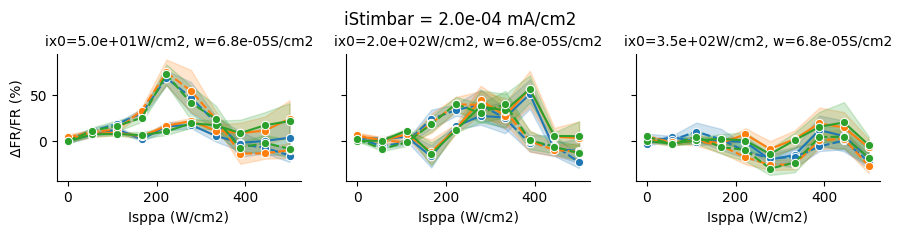

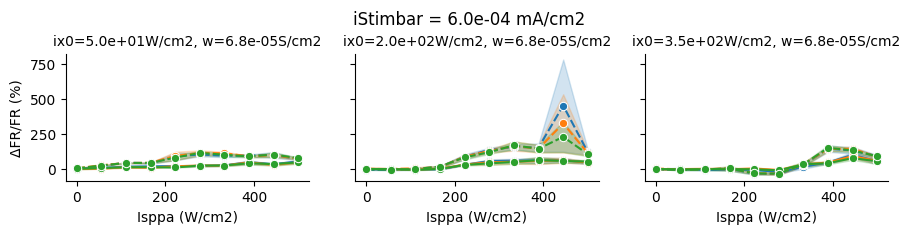

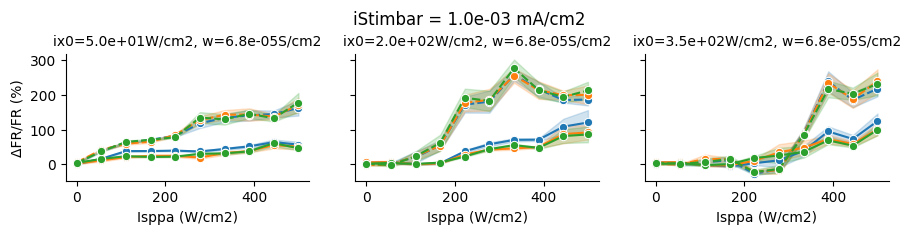

In [17]:
# Define vector of coupling strengths (in S/cm2)
wrange = np.array([4]) * model.g_RS_RS
iStimx0_range = np.linspace(50, 350, 3)  # W/cm2
iStimbar_range = np.linspace(2e-4, 1e-3, 3).round(4)  # mA/cm2

Isppa_range_old = Isppa_range
Isppa_range = np.linspace(0, 500, 10)

nreps = 6

# For each stimulus sensitivity
for iStimbar in iStimbar_range:
    # Set maximum stim-driven current amplitude to current value
    model.set_mech_param(iStimbar=iStimbar)

    # For each stimulus sensitivity
    data, keys = [], []
    for iStimx0 in iStimx0_range:
        model.set_mech_param(iStimx0=iStimx0)
        # For each coupling strength
        for w in wrange:
            model.set_synaptic_weight(w)
            # For each stimulus distribution
            for k, xvec in dists.items():
                # Run sweep over stimulus intensities, and append results to list
                data.append(model.run_stim_sweep(Isppa_range, stimdist=xvec, nreps=nreps))
                keys.append((iStimx0, w, k))

    # Concatenate results
    data = pd.concat(data, keys=keys, names=['iStimx0 (W/cm2)', 'w (S/cm2)', 'stim dist.'])

    # Reset gamma and synaptic weight to their default values
    model.set_mech_param(iStimx0=params['iStimx0'])
    model.set_synaptic_weight(model.g_RS_RS)

    # Plot results
    logger.info('plotting results...')
    fg = sns.FacetGrid(
        data.reset_index(),
        col='iStimx0 (W/cm2)',
        row='w (S/cm2)',
        aspect=1.5,
        height=2,
    )
    fg.set_titles('ix0={col_name:.1e}W/cm2, w={row_name:.1e}S/cm2')
    for iw, w in enumerate(wrange):
        for ix, iStimx0 in enumerate(iStimx0_range):
            gdata = data.loc[iStimx0, w]
            model.plot_sweep_results(
                gdata, model.RESP_KEY, 
                ax=fg.axes[iw, ix], legend=iw == 1 and ix == 2)
    fig = fg.figure
    fig.suptitle(f'iStimbar = {iStimbar:.1e} mA/cm2', y=1.05)

# Reset maximum stim-driven current amplitude to default value
model.set_mech_param(iStimbar=params['iStimbar'])

# Reset stimulus amplitude to reference value
model.set_stim(Iref)

## Log completion

In [11]:
logger.info(f'notebook completed in {timedelta(seconds=time.perf_counter() - t0)}')

 03/12/2023 19:28:40: notebook completed in 0:05:14.231183
